# 의료영상 분석하기

## 1. Set-up

#### 모듈 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'  # *은 모든 디렉토리와 파일
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트 진행할 때 변경해 볼 하이퍼파라미터
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


---

## 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) # train 데이터 개수
print(len(test_filenames)) # test 데이터 개수
print(len(val_filenames)) # validation 데이터 개수

5216
624
16


validation 개수가 너무 적으므로 train과 합친 뒤 다시 20%를 validation 데이터로 새로 분리해야 한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해야 하는데,
<br> 파일 경로를 살펴보면 정상이미지는 NORMAL이 들어가고, 폐렴이미지는 PNEUMONIA가 들어간다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


train 데이터셋에서 클래스 불균형이 일어난다. 차후에 조정할 예정이다.
<br> 참고로 test와 val 데이터셋은 imbalance해도 상관없다.

tenserflow에서 학습시킬 때 mini-batch로 작업할 수 있도록 도와주는 tf.data 인스턴스를 만들어보자.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train 데이터셋과 validation 데이터셋 개수를 확인해보자.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다. 라벨 데이터 만들어주는 함수를 만들어보자.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈를 줄이는 함수를 만들어보자.
<br> (이미지의 사이즈 통일, GPU 메모리 효율적으로 사용하기 위해)

In [10]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만들어보자.

In [11]:
# num_parallel_calls 파라미터에 AUTOTUNE 변수를 이용하면 더욱 빠르게 데이터 처리 가능
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인해보자.

In [12]:
for image, label in train_ds.take(1):  # 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터셋도 만들어보고 데이터 개수 확인해보자.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인을 이용해서 학습 데이터를 효율적으로 사용할 수 있게,
<br> prepare_for_training() 함수를 정의해서 데이터를 변환시켜주자.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하며 필요한 데이터셋을 여러번 사용할 수 있게 해줌 (자동으로 데이터를 맞춰줌)
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 데이터가 나누어지게 됨
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습데이터를 나눠서 읽어오므로 리소스의 유휴상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

---

## 3. 데이터 시각화

데이터를 시각화하기 위해 train에 있는 batch 중 첫번째 배치를 추출하고,
<br> image와 label 데이터셋으로 나눈다. 결과 사진을 보기 위해 show_batch() 함수를 만들어보자.

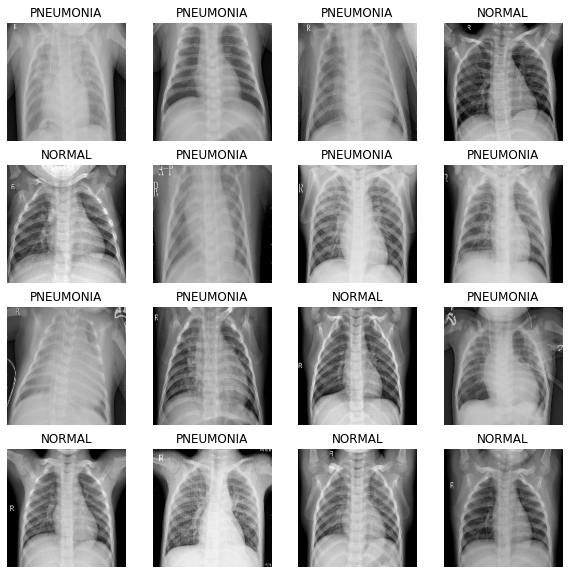

In [15]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

---

## 4. CNN 모델링

In [16]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense block 만드는 함수

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---

## 5. 데이터 imbalance 처리

> **Weight balancing** : training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 방법
<br> [딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

In [19]:
# weight들을 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


---

## 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이므로 먼저 GPU를 선택한다.
<br> 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.
<br> 이미지의 라벨이 두 개 밖에 없으므로 loss는 binary_cross entropy를 사용한다.
<br> optimizer는 'adam'을 사용한다.
<br> 성과에 대해 측정하기 위한 Metrics로 accuracy, precision, recall을 사용한다.

In [20]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)

In [21]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 86s 194ms/step - loss: 0.3811 - accuracy: 0.8142 - precision: 0.9523 - recall: 0.7898 - val_loss: 0.6603 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2259 - accuracy: 0.9107 - precision: 0.9750 - recall: 0.9032 - val_loss: 1.1950 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1995 - accuracy: 0.9265 - precision: 0.9775 - recall: 0.9223 - val_loss: 0.9737 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1852 - accuracy: 0.9291 - precision: 0.9782 - recall: 0.9253 - val_loss: 0.0766 - val_accuracy: 0.9760 - val_precision: 0.9881 - val_recall: 0.9791
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1559 - accura

---

## 7. 결과 확인

그래프로 Epochs마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다.

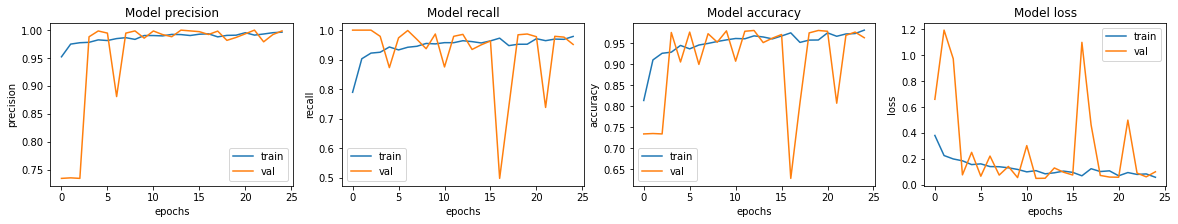

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델을 평가해보자. (loss, accuracy, precision, recall 값 출력)

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.8662 - accuracy: 0.8301 - precision: 0.8034 - recall: 0.9641
Loss: 0.8661874532699585,
Accuracy: 0.8301281929016113,
Precision: 0.8034188151359558,
Recall: 0.964102566242218


정확도가 약 80%가 조금 넘고, Recall값은 꽤 높다.
<br> 성능 개선을 위해 다양한 방법이 필요하다.

---

---

# 폐렴 진단기 성능개선

X-RAY 사진 판독 폐렴 진단기의 정확도를 85% 이상으로 올리기 위해 여러가지 사항을 변경해보고자 한다.

**변경 적용해 볼 사항**
- (Step 1) 실험환경 Set-up : Batch size, Epoch 등 변경
- (Step 2) 데이터 준비하기 : Data Augmentation 도입
- (Step 4) CNN 모델링 : Convolution filter, 채널 개수, activation, 모델 구조 등 변경 가능 / BatchNormalization과 Dropout을 동시에 쓰지 않기
- (Step 5) 데이터 imbalance 처리 : class weight 생략 / recall을 강조하기 위해 폐렴데이터 weight 가중치 더 강화
- (Step 6) 모델 훈련: optimizer, learning rate 등 변경


### <첫번째 시도>

이 중에 나는 Data Augmentation을 도입해보고, BatchNormalization을 없애고 Dropout만 쓰는 것으로 변경해보겠다.

#### Data Augmentation 도입

In [24]:
# dataset 다시 세팅
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [25]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # augment 함수 적용
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 데이터 시각화

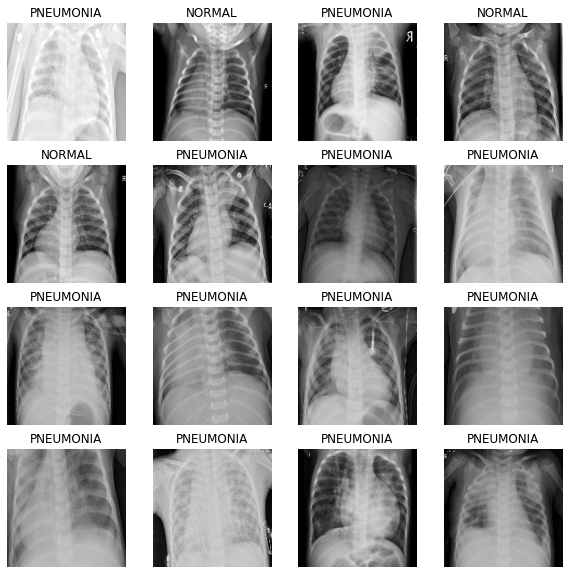

In [26]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### CNN 모델링

In [27]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense block 만드는 함수

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 모델 훈련

In [28]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)


In [29]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 182ms/step - loss: 0.6940 - accuracy: 0.4397 - precision: 0.7489 - recall: 0.3714 - val_loss: 0.6841 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.6928 - accuracy: 0.6468 - precision: 0.7437 - recall: 0.8023 - val_loss: 0.6895 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.6944 - accuracy: 0.4672 - precision: 0.7376 - recall: 0.4393 - val_loss: 0.6842 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.6950 - accuracy: 0.5682 - precision: 0.7359 - recall: 0.6531 - val_loss: 0.6929 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 48s 184ms/step - loss: 0.6932 - accura

#### 결과 확인

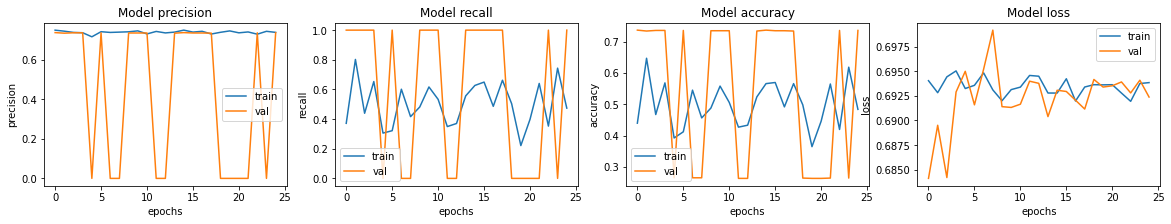

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.6927 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6927399039268494,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


Recall값이 1이지만 나머지값이 개판이다. 뭔가 너무 잘못되었다는 것을 깨달았다.
<br> 생각해보니 데이터 augmentation 해줄 때 좌우반전한 사진들을 추가해주는 것이 더 혼란을 가중시킬 수 있다는 생각이 들었다. x-ray 사진 상에서만 확인해봐도 우리 폐나 구조가 좌우대칭이 되어있지 않고 모양이 정해져있는데 가뜩이나 데이터 양이 적은 상태에서 모델에게 혼란만 더 준 것 같아서 미안했다.

---

### <두번째 시도>

그냥 원래 데이터를 사용하고 모델링 과정에서 Dropout을 빼고 BatchNormalization만 진행해보기로 했다.

In [32]:
# dataset 다시 세팅
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [33]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하며 필요한 데이터셋을 여러번 사용할 수 있게 해줌 (자동으로 데이터를 맞춰줌)
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 데이터가 나누어지게 됨
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습데이터를 나눠서 읽어오므로 리소스의 유휴상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [34]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense block 만드는 함수

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [44]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)

In [45]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 191ms/step - loss: 0.2222 - accuracy: 0.9071 - precision: 0.9785 - recall: 0.8947 - val_loss: 0.6685 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1616 - accuracy: 0.9394 - precision: 0.9811 - recall: 0.9366 - val_loss: 0.8641 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1422 - accuracy: 0.9425 - precision: 0.9831 - recall: 0.9388 - val_loss: 0.1421 - val_accuracy: 0.9375 - val_precision: 0.9288 - val_recall: 0.9908
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1123 - accuracy: 0.9610 - precision: 0.9877 - recall: 0.9594 - val_loss: 0.0759 - val_accuracy: 0.9731 - val_precision: 0.9817 - val_recall: 0.9817
Epoch 5/25
261/261 [==============================] - 51s 194ms/step - loss: 0.0875 - accura

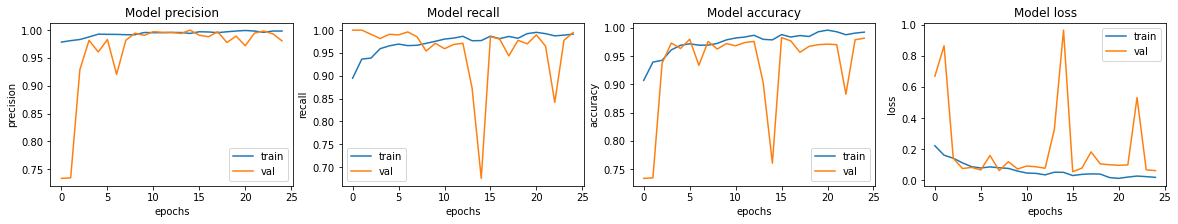

In [46]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.3619 - accuracy: 0.7532 - precision: 0.7169 - recall: 1.0000
Loss: 1.3619180917739868,
Accuracy: 0.7532051205635071,
Precision: 0.716911792755127,
Recall: 1.0


평가지표들이 그래프 상에서 워낙 들쭉날쭉한 것 같아서 잠시 Epochs를 줄여봤는데 더 안좋은 결과를 보여줘서 다시 25로 고정시켰다.
<br>그냥 BatchNormalization과 Dropout을 같이 쓰는 것이 맞나보다. 의료 영상 데이터에 대해 둘을 같이 쓰는 경우가 더 정확할 수 있는 것 같다.

---

### <세번째 시도>

이번엔 처음으로 다시 돌아가서, Dropout의 비율을 미세하게 높여보았다.

In [59]:
# dataset 다시 세팅
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [60]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하며 필요한 데이터셋을 여러번 사용할 수 있게 해줌 (자동으로 데이터를 맞춰줌)
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 데이터가 나누어지게 됨
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습데이터를 나눠서 읽어오므로 리소스의 유휴상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [61]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense block 만드는 함수

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [62]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)

In [63]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 192ms/step - loss: 0.4276 - accuracy: 0.7900 - precision: 0.9456 - recall: 0.7613 - val_loss: 0.6521 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2614 - accuracy: 0.8889 - precision: 0.9671 - recall: 0.8806 - val_loss: 1.3695 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2126 - accuracy: 0.9188 - precision: 0.9746 - recall: 0.9147 - val_loss: 0.2373 - val_accuracy: 0.8971 - val_precision: 0.8772 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1966 - accuracy: 0.9203 - precision: 0.9769 - recall: 0.9143 - val_loss: 0.0778 - val_accuracy: 0.9740 - val_precision: 0.9894 - val_recall: 0.9751
Epoch 5/25
261/261 [==============================] - 50s 194ms/step - loss: 0.1856 - accura

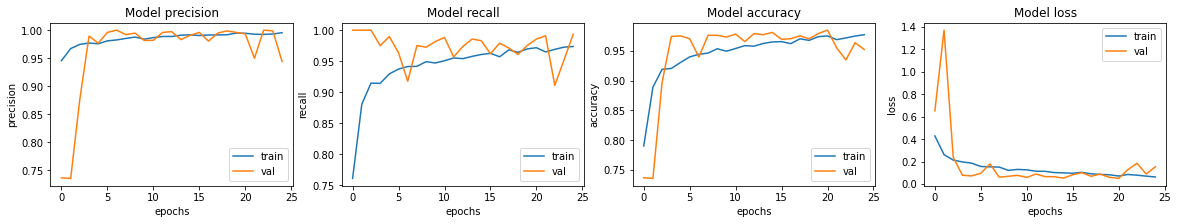

In [64]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 2.0196 - accuracy: 0.6875 - precision: 0.6667 - recall: 1.0000
Loss: 2.019585371017456,
Accuracy: 0.6875,
Precision: 0.6666666865348816,
Recall: 1.0


계속 시도해봐도 처음 세팅만큼 유지하기가 힘들다.

---

### <네번째 시도>

이번엔 처음 세팅에서 optimizer의 learning rate만 바꾸어보겠다.

In [66]:
# dataset 다시 세팅
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [67]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하며 필요한 데이터셋을 여러번 사용할 수 있게 해줌 (자동으로 데이터를 맞춰줌)
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 데이터가 나누어지게 됨
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습데이터를 나눠서 읽어오므로 리소스의 유휴상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [68]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense block 만드는 함수

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [69]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam의 Learning rate를 default값인 0.001에서 0.0001로 변경
                 loss='binary_crossentropy',
                 metrics=METRICS)

In [70]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 191ms/step - loss: 0.5426 - accuracy: 0.7100 - precision: 0.9309 - recall: 0.6592 - val_loss: 0.6759 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.3771 - accuracy: 0.8120 - precision: 0.9720 - recall: 0.7696 - val_loss: 0.5880 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.3090 - accuracy: 0.8573 - precision: 0.9707 - recall: 0.8332 - val_loss: 0.2721 - val_accuracy: 0.9442 - val_precision: 0.9771 - val_recall: 0.9464
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2599 - accuracy: 0.8877 - precision: 0.9800 - recall: 0.8668 - val_loss: 0.2509 - val_accuracy: 0.9212 - val_precision: 0.9957 - val_recall: 0.8969
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2430 - accura

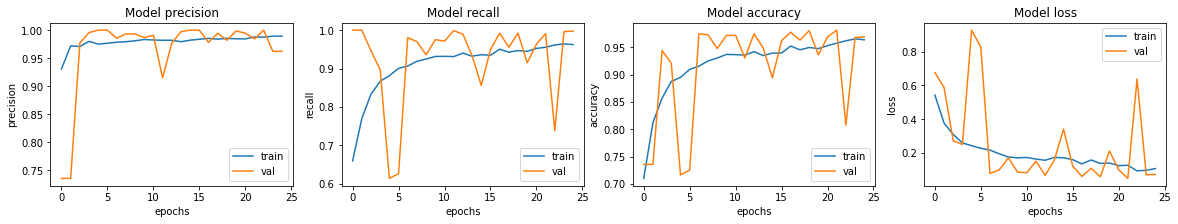

In [71]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 1.1477 - accuracy: 0.6923 - precision: 0.6701 - recall: 1.0000
Loss: 1.147686243057251,
Accuracy: 0.692307710647583,
Precision: 0.6701030731201172,
Recall: 1.0


---

### <다섯번째 시도>

이번엔 다시 데이터 쪽이 문제인가 싶어서 초기 세팅에서 데이터 imbalance 처리, 즉 class_weight를 없애주었다.

In [87]:
# dataset 다시 세팅
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [88]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='Adam', 
                  loss='binary_crossentropy',
                  metrics=METRICS)

In [89]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/25
261/261 [==============================] - 58s 186ms/step - loss: 0.3777 - accuracy: 0.8374 - precision: 0.9363 - recall: 0.8383 - val_loss: 0.8407 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.2235 - accuracy: 0.9229 - precision: 0.9482 - recall: 0.9482 - val_loss: 1.6964 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1715 - accuracy: 0.9375 - precision: 0.9593 - recall: 0.9565 - val_loss: 0.1045 - val_accuracy: 0.9615 - val_precision: 0.9560 - val_recall: 0.9935
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1651 - accuracy: 0.9418 - precision: 0.9611 - recall: 0.9607 - val_loss: 0.1355 - val_accuracy: 0.9413 - val_precision: 0.9293 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1479 - accura

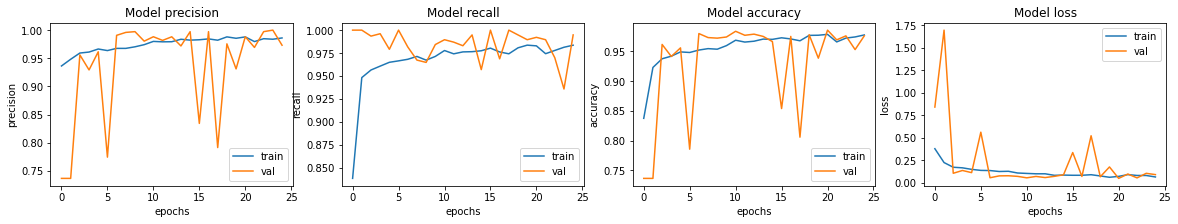

In [90]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [91]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 1.6453 - accuracy: 0.7340 - precision: 0.7029 - recall: 0.9949
Loss: 1.6452826261520386,
Accuracy: 0.7339743375778198,
Precision: 0.7028985619544983,
Recall: 0.9948717951774597


여기까지 오니깐 문제는 하이퍼파라미터들이 아니었던 것 같다. 캐글을 들어가서 여러 훌륭한 사람들의 노트북을 뒤져보니 ImageDataGenerator라는 것을 써서 데이터 augmentation을 제대로 사용해줘야 한다는 것을 알았다.

---

### <여섯번째 시도>

ImageDataGenerator 써보자. 아예 데이터 지정단계부터 다시 시작.

ImageDataGenerator의 인자들
- rotation_range : 이미지회전값
- zoom_range : 이미지일부확대
- shear_range : 이미지기울기
- width_shift_range : 좌우이동
- height_shift_range : 상하이동
- horizontal_flip : 이미지가로뒤집기
- vertical_filp : 이미지세로뒤집기

In [118]:
from keras.preprocessing.image import ImageDataGenerator

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [64, 64]    # 이미지 사이즈 (180, 180) -> (64, 64)로 변경

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test'

# 하이퍼파라미터
BATCH_SIZE = 16
EPOCHS = 25
class_weight = {0: weight_for_0, 1: weight_for_1}

In [119]:
# Augmentation 인자 지정해주기

train_datagen = ImageDataGenerator(rescale=1./255,  # 픽셀값 스케일을 조정
                                   validation_split=0.2,  # val 개수가 16개라 버리고 train에서 분리해줄 예정
                                  shear_range=0.2,  # 이미지 기울기 정도
                                  zoom_range=0.2,   # 이미지 일부 확대
                                  horizontal_flip=True) # 이미지 좌우 뒤집기
val_datagen = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [120]:
# Generator 지정

train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                             subset='training')
val_gen = val_datagen.flow_from_directory(TRAIN_PATH,
                                          target_size=IMAGE_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary',
                                         subset='validation')
test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMAGE_SIZE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [121]:
# 라벨링 잘 되어있는지 확인

train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

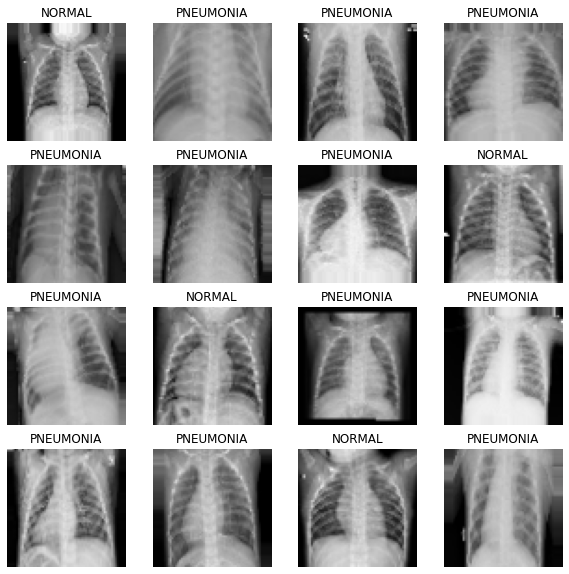

In [122]:
# 이미지 시각화

batch = train_gen.next()

plt.figure(figsize=(10,10))
for n in range(BATCH_SIZE):
    ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
    plt.imshow(batch[0][n])
    if batch[1][n]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")
plt.show()

In [123]:
# Convolution block 만드는 함수

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense block 만드는 함수

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# 모델링 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [124]:
# 모델링

with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)

In [125]:
# 모델 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        steps_per_epoch=4173 // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=1043 // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
260/260 [==============================] - 57s 211ms/step - loss: 0.5461 - accuracy: 0.7479 - precision: 0.9211 - recall: 0.7225 - val_loss: 0.6339 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 2/25
260/260 [==============================] - 54s 209ms/step - loss: 0.3435 - accuracy: 0.8622 - precision: 0.9528 - recall: 0.8569 - val_loss: 0.9864 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/25
260/260 [==============================] - 54s 209ms/step - loss: 0.2926 - accuracy: 0.8807 - precision: 0.9609 - recall: 0.8750 - val_loss: 0.4031 - val_accuracy: 0.7798 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 4/25
260/260 [==============================] - 55s 210ms/step - loss: 0.2654 - accuracy: 0.8975 - precision: 0.9703 - recall: 0.8892 - val_loss: 0.5281 - val_accuracy: 0.7817 - val_precision: 1.0000 - val_recall: 0.7063
Epoch 5/25
260/260 [==============================] - 54s 209ms/step - loss: 0.2601 - accura

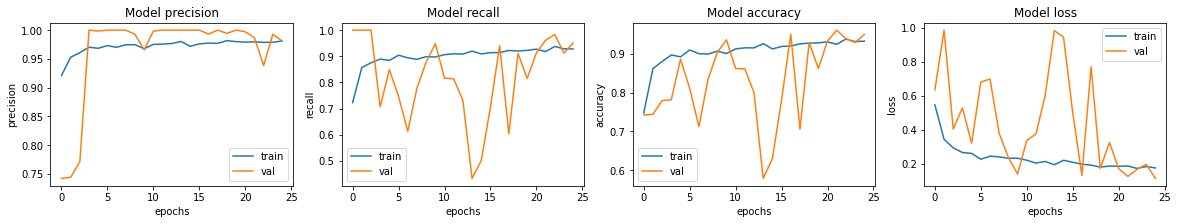

In [126]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [127]:
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 129ms/step - loss: 0.4537 - accuracy: 0.8766 - precision: 0.8486 - recall: 0.9769
Loss: 0.4536539614200592,
Accuracy: 0.8766025900840759,
Precision: 0.8485523462295532,
Recall: 0.9769230484962463


Accuracy가 드디어 87%가 되었다.

---

## 회고

- 제일 초기의 accuracy가 83%로 꽤 높아서, 금방 85%를 넘길 수 있을 줄 알았다. 그래서 처음에 좌우 반전된 사진들을 섞어주는 Data augmentation을 시도했고, BatchNormalization을 빼주었다. 나는 당연히 Data augmentation이라고 해서 기존에 있던 train data에 더 많은 데이터를 추가하여 양을 늘려주는 것이라 생각했는데, 다시 생각해보니 train data의 양은 그대로였고, 그 안에서 변형을 해주는 것 뿐이었다. 그래서 그런지 첫 시도는 62%의 accuracy를 기록하며 처절하게 실패했다. 데이터 양이 가뜩이나 적은데 그 중에 좌우 반전된 사진들로 몇 가지를 바꿔준다고 해서 더 정확해질리 없는 것이었다. 모델에게 혼란만 준 것 같았다. 그리고 BatchNormalization을 빼니깐 데이터들이 더 들쭉날쭉해진 상태가 될 것이었고, 그 상황에서 Dropout만 적용해주니 학습을 건너뛰는 부분이 많아지면서 정확도가 확 내려간 것 같았다.
<br>(이 부분을 할 때 데이터를 시각화하는 부분에서 커널이 자꾸 죽어서 초기화되었다. 몇 번을 시도해봐도 자꾸 그래서 속상했는데, 알고보니 그 전 시도에서 데이터를 가공한 상태에서 다음 시도로 넘어갈 때 데이터를 다시 불러와줬어야 했는데, 그 작업을 안하고 이미 그 전에 가공되어져 있던 데이터를 쓰니 뭔가 앞 뒤가 안맞기도 했고, 정상적인 단계로 진행되지 못해서 커널이 죽었던 것 같다.)
- 그래서 두 번째 시도에서는 Data augmentation을 포기하고 BatchNormalization을 다시 넣어주고, Dropout을 빼주었다. 그랬더니 직전보다는 정확도가 75%로 올라갔지만, 80%도 넘기지 못하고, BatchNormalization과 Dropout을 같이 써주는 것보다 효과가 훨씬 좋지 않다는 것을 알았다. 그래서 그 다음부터는 계속 두 가지를 같이 써봤다.
- 세 번째 시도에서는 그 두 가지를 같이 써보면서 Convolution Layer 뒤에 오는 Dropout의 비율을 0.2에서 0.3으로 나름 미세하게(?) 높여봤다. 그랬더니 정확도가 다시 60%대로 떨어졌다. 어떤 위치에서의 Dropout의 비율을 조절해야 할지 다음에 좀 더 공부할 필요가 있는 것 같다. 그래서 아예 그 다음에는 Dropout의 비율도 그대로 두었다.
- 네 번째 시도에서는 다 그대로 두고, 모델의 optimizer인 'Adam'의 learning rate를 default값인 0.001에서 0.0001로 낮추어봤다. 여전히 정확도가 60%대에 머물러서 좌절했다. 
- 노드를 찬찬히 살펴보니, 클래스 불균형 문제를 해소할 class_weight를 변형시키는 방법도 한번 적용해봐야 되겠다고 생각했다.그래서 처음에는 수가 적은 NORMAL 데이터의 가중치를 2로 올리고, PNEUMONIA 데이터의 가중치를 0.5로 낮추었는데, 너무 말도 안되는 정확도가 나와서 아예 class_weight를 없애보았다. 그랬더니 정확도는 다시 70%대로 올랐는데, 아직도 80%를 넘지 못하는 것이 내가 잘못된 방향으로 계속 시도를 하고 있는게 아닌가라는 회의감이 들었다.
- 그냥 이대로 제출할까 하고 반쯤 포기한 상태에서, 갑자기 문득 이것이 캐글에서 따온 실습문제라는 것이 생각이 나서, 캐글에 가서 다른 훌륭하신 분들의 노트북들을 찬찬히 살펴보았다. 봤더니 대부분 ImageDataGenerator라는 것으로 데이터 augmentation을 진행해서 문제를 해결하는 식이었다. 근데 내 것에 적용하기가 너무 어렵고 막막해서 쓸 엄두가 안났는데, 아예 내 데이터를 처음부터 다시 설정해보자고 생각하고 차근차근히 적용시켜 나가면서 시행착오를 겪다보니 흉내라도 낼 수 있게 되었다. 뭔가 이전 단계에서 Data augmentation을 적용할 당시에 폐 x-ray 사진들의 크기나 기울기 등이 일정하지 않은 것 같아서 그런 것들을 보완할 수 있으면 좋겠다 생각했는데, ImageDataGenerator로 어느 정도 해결할 수 있었다. 그리고 계속 이미지 사이즈를 (180, 180)으로 유지하는 것보다 (64, 64) 정도로 줄여서 넣는 것이 더 정확도를 높일 수 있다는 아이디어도 캐글 노트북들을 통해서 확인하였다. 덕분에 accuracy도 87%대로 많이 상승했다.
- 오랫동안 답이 보이지 않는 프로젝트였는데, 결과적으로 기준을 충족시킬 수 있어서 다행이었다. 다음에 ImageDataGenerator를 또 쓸 수 있는 프로젝트에서 한번 제대로 적용해보고 싶다. 연습을 통해서 익숙해져야겠다.
- 실제로 의료 영상을 다루는 분야에서는 정확도가 훨씬 많이 올라가야 할 것이다. 데이터의 양도 훨씬 충분히 많아야하고, 클래스 불균형의 문제도 해결되고 극복할 수 있는 방법을 많이 연구해야 할 것 같다. 그리고 accuracy뿐만 아니라 precision과 recall값에 대해서도 더 올릴 수 있는 방향으로 고민해볼 필요가 있을 것이다. 여러모로 힘들었지만 생각해볼 부분도 많고 공부가 많이 되는 프로젝트였다.
<br>(캐글 노트북들을 보니 재밌는 시도를 한 분들이 많다. 이런 것들을 읽는 것만으로도 진짜 도움이 많이 되는 것 같다.)